Import Dependencies
-

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

import time
import sys

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

Define Synthetic Model
-
Given d-dimensional feature space, the synthetic_model() mathemtatically defines a ground truth decision boundary, such that all points within the bounds of a solution cluster are all a distance r from the source node position

In [433]:
source_node = Node(np.asarray([0,0]), 0) #Want to explain this value
query_node = Node(np.asarray([11,5]), 0)

#Define scaling for features in synthetic "training data"
feat_ranges = np.zeros(len(source_node.position)) + 200 #Assume all features have range 1000
feat_scaler = 1/np.asarray(feat_ranges)
    

#Want GD-FETS to recreate these stability values thorugh local search
ground_truth_importance = {}
ground_truth_importance[(1,0)] = 30
ground_truth_importance[(1,1)] = 60
ground_truth_importance[(-1,0)] = 120
ground_truth_importance[(0,0)] = 200 #default for every other feature interaction

In [434]:
#Non-linear example of synethetic model
def query_synth_model(ground_truth_importance, source_node, query_node):
    
    #Determine cluster of query_node
    solution_clusters, full_cluster = cluster_feat_int(source_node, query_node, {}, feat_scaler, 1)
    cluster = tuple(list(solution_clusters.keys())[0])
    relative_position = query_node.position - source_node.position
    
    # create n feature hyper-arc specific to cluster
    distance = 0
    for term in relative_position:
        distance += abs(term) ** 2
    distance = distance ** 0.5
        
    if cluster in ground_truth_importance.keys():
        decision_threshold = ground_truth_importance[cluster]
    else:
        default_index = tuple(np.zeros(len(relative_position)))
        decision_threshold = ground_truth_importance[default_index]
        
    if distance < decision_threshold:
        return 0
    else:
        return 1

Generate Training Data
-

(5000, 2)

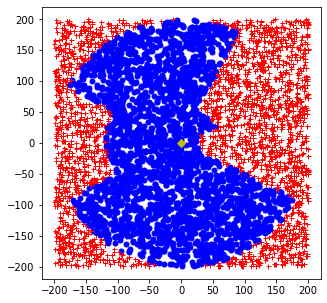

In [435]:
#Create "training data" to use for calculating feat_ranges to infer search step sizes
fig, ax = plt.subplots(figsize = (5, 5))
#plt.ylim(-2,2)
#plt.xlim(-2,2)

feat_range = feat_ranges[0]
nfeats = len(source_node.position)
data = []
labels = []
nsamp = 5000
for _ in range(nsamp):
    point = np.random.uniform(low=-1*feat_range, high=feat_range, size=(nfeats,))
    query_node = Node(point, None)
    rec = query_synth_model(ground_truth_importance, source_node, query_node)
    data.append(point)
    labels.append(rec)
    
    if rec == 0:
        plt.plot(point[0],point[1],'bo',markersize=5)
    else:
        plt.plot(point[0],point[1],'r+',markersize=5)

plt.plot(source_node.position[0],source_node.position[1],'yD',markersize=5)
data = pd.DataFrame(data)
data.shape

(1000, 2)

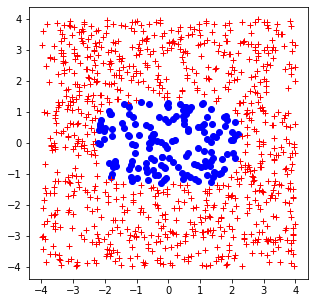

In [108]:
#Linear example of synthetic model
#Synthetic model to be used as an objective ground truth measure of explainability, using feature instability as a proxy  
def query_synth_model(node):
    point = node.position
    if (1/9*point[0]**4) + (point[1]**4) < 3:
        return 1
    else:
        return 0
        
source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
query_synth_model(source_node)

#Create "training data" to use for calculating feat_ranges to infer search step sizes
fig, ax = plt.subplots(figsize = (5, 5))
#plt.ylim(-2,2)
#plt.xlim(-2,2)

nfeats = 2
dense_features = np.arange(nfeats)
data = []
labels = []
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-4, high=4, size=(nfeats,))
    node = Node(point, None)
    rec = query_synth_model(node)
    data.append(point)
    labels.append(rec)
    
    if rec == 1:
        plt.plot(point[0],point[1],'bo')
    else:
        plt.plot(point[0],point[1],'r+')

data = pd.DataFrame(data)
data.shape

In [443]:
def get_num_range(data, dense_features):
    #Returns (range) of values for each I1-I13 integer features
    num_data_distrib = []
    for feat in dense_features:
        feature = data[feat]
        #num_data_distrib.append([feature.min(), feature.max(), np.std(feature), feature.mean()])
        #num_data_distrib.append([feature.min(), feature.max(), feature.max() - feature.min()])
        #num_data_distrib.append([feature.max() - feature.min()])
        num_data_distrib.append(3 * np.std(feature)) #Range contains 99.7% of samples in training data
    
    return np.asarray(num_data_distrib)
    
feat_ranges = get_num_range(data, dense_features)
print(feat_ranges.shape)
feat_ranges

(2,)


array([350.29587355, 345.67573273])

In [153]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

In [417]:
def get_distance(source_node, query_node, feat_scaler, distance='Manhattan'):
    #returns distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = (dif / feat_scaler)
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)
    
prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=5, k=100)

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100

In [416]:
    
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        v_hat = v / np.linalg.norm(v)
        vectors.append(v_hat)
    return vectors


def generate_precursor_solutions(source_node, feat_ranges, k=20, nsteps=6, plot_search=False):

    step_sizes = (feat_ranges/nsteps) #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.arange(step_sizes[feat],feat_ranges[feat],step_sizes[feat]))
    feat_steps = np.asarray(feat_steps)
    
    source_rec = query_synth_model(ground_truth_importance, source_node, source_node)
    
    if plot_search:
        plt.plot(source_node.position[0],source_node.position[1],'r+')

    discovered = []

    while len(discovered) < k:
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        for step in range(nsteps-1):
            scaled_vector_position = np.asarray(unit_vector * feat_steps.T[step] + source_node.position)
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_synth_model(ground_truth_importance, source_node, scaled_vector)
            
            if plot_search:
                if query_rec == source_rec:
                    color = 'bo'
                else:
                    color = 'y^'
                plt.plot(scaled_vector.position[0],scaled_vector.position[1],color)
            
            if source_rec != query_rec:
                # distance heuristic
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                print(len(discovered),end='')
                break
    
    return discovered

In [169]:
#TODO: Adapative gradient to make largest jumps in k-closest solutions in beginning, then lower over time

def find_adjs(node, feat_scaler, learning_rate):
    #Returns all nodes adjacent to current solution in ndim feature space
    
    adj_nodes = []
    pos = node.position
    for dim in range(len(pos)):
        #Check if dim is a missing value, as marked in cat_dims_to_emb()
        if pos[dim] != None:
            temp = pos.copy().astype(float)
            temp[dim] += learning_rate / feat_scaler[dim]
            adj_nodes.append(Node(temp, None))
            temp = pos.copy().astype(float)
            temp[dim] -= learning_rate / feat_scaler[dim]
            adj_nodes.append(Node(temp, None))
    return adj_nodes


# If the query_node is too close to an existing solution, it is omitted to encourage discovery of new
# territory along the decision boundary
def neighboring_solution(discovered, query_node, neighborhood_size, feat_scaler):

    for solution in discovered:
        distance = get_distance(solution, query_node, feat_scaler)
        if distance < neighborhood_size:
            return True
    
    return False


#A* without clustering constraint
def a_star_search(source_node, prelim_discovered, feat_ranges, k=100, learning_rate=0.25):
    
    #Analytics to inform how to handle degree of branching
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    visited = {} # True corresponds to visited for low complexity "visited" search
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    source_rec = query_synth_model(source_node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    #TODO: Want to define stop criteria based on no solutions approaching center
    while frontier and len(discovered) < k:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check goal state
        query_rec = query_synth_model(query_node)
        if query_rec != source_rec:
            #Do not use solution if previous discovered is in close neigborhood
            if not neighboring_solution(discovered, query_node, learning_rate, feat_scaler):
                discovered.append(query_node)
                visited[tuple(query_node.position)] = True
                #print("soln:",query_node.position)
                print(len(discovered),end=' ')
                
 
        #Add adjacents to priority queue before visiting them
        adjs = find_adjs(query_node, feat_ranges, learning_rate) #every node adjacent to the current node
        for adj_node in adjs:
            
            in_bfet = True
            for i in range(len(adj_node.position)):
                if adj_node.position[i] >= feat_ranges[i] or adj_node.position[i] <= -1*feat_ranges[i]:
                    in_bfet = False
            
            if in_bfet and tuple(adj_node.position) not in visited.keys():
                
                adj_node.distance = get_distance(source_node, adj_node, feat_scaler)
                heapq.heappush(frontier, adj_node)
                visited[tuple(adj_node.position)] = True
                nodes_generated += 1
    
    print("Nodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)
    print("Visited Length:",len(visited))

    return discovered

----

In [400]:
# Puts solution node into a n-way feature interaction cluster
def cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler, max_cluster_size):
    
    realative_node_pos = (query_node.position - source_node.position) #Projects pos of query relative to source
    scaled_feats = (realative_node_pos * feat_scaler) #[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    f_ratios = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                f_ratios[f_i] = 1
            else:
                f_ratios[f_i] = -1
                        
    if tuple(f_ratios) not in solution_clusters:
        solution_clusters[tuple(f_ratios)] = []
    #Add solution to cluster if f_ratios isn't overrepresented in solution_clusters
    full_cluster = False
    if len(solution_clusters[tuple(f_ratios)]) < max_cluster_size:
        solution_clusters[tuple(f_ratios)].append(query_node.position)
        #print('  CFI',node.position)
        
    else:
        full_cluster = True
    
    return solution_clusters, full_cluster

In [300]:
sorted_clusters

array([[24216.318508836215, (1.0, 0.0)],
       [97844.31929058803, (-1.0, 1.0)],
       [98397.40249617776, (-1.0, -1.0)],
       [76061.66428719898, (0.0, 1.0)],
       [48503.931819547186, (-1.0, 0.0)],
       [96925.42134616167, (1.0, -1.0)],
       [33090.281487117914, (1.0, 1.0)],
       [73910.33261558735, (0.0, -1.0)]], dtype=object)

In [302]:
temp = sorted_clusters.copy()
ind = temp.argsort(axis=0)
temp[:,0] = temp[:,0][ind[:,0]]
temp[:,1] = temp[:,1][ind[:,0]]
temp

array([[24216.318508836215, (1.0, 0.0)],
       [33090.281487117914, (1.0, 1.0)],
       [48503.931819547186, (-1.0, 0.0)],
       [73910.33261558735, (0.0, -1.0)],
       [76061.66428719898, (0.0, 1.0)],
       [96925.42134616167, (1.0, -1.0)],
       [97844.31929058803, (-1.0, 1.0)],
       [98397.40249617776, (-1.0, -1.0)]], dtype=object)

In [293]:
ind[:,1]

array([2, 4, 1, 7, 3, 5, 0, 6])

In [307]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    
    sorted_clusters = np.asarray(sorted_clusters)
    ind = sorted_clusters.argsort(axis=0)
    sorted_clusters[:,0] = sorted_clusters[:,0][ind[:,0]]
    sorted_clusters[:,1] = sorted_clusters[:,1][ind[:,0]]
    
    return sorted_clusters

In [172]:
def display_instability(sorted_clusters):
    x = [str(feat_interaction[1]) for feat_interaction in sorted_clusters]
    energy = [1/feat_interaction[0] for feat_interaction in sorted_clusters]
    variance = [0 for _ in x]

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, energy, color='blue', yerr=variance)
    plt.xlabel("Feature Interaction")
    plt.ylabel("Feature Instability \n(1/Distance from Source to Alternate Rec)")
    plt.title("Instability of Feature Interactions \n in Recommending <Source Node>")

    plt.xticks(x_pos, x)

    font = {'weight' : 'bold',
            'size'   : 12}

    #matplotlib.rc('font', **font)

    #plt.rcParams["figure.figsize"] = (5,5)
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.show()

In [497]:
#A* with solution cluster tracking
# k = number of total opposite rec solutions
def a_star_search(source_node, prelim_discovered, feat_ranges, k=100, learning_rate=1, max_cluster_size=100):
    
    #Analytics to inform how to handle degree of branching
    nodes_generated = 0
    nodes_visited = 0
    denied_cluster = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation... redundant with solution_clusters{} now
    visited = {} # True corresponds to visited for low complexity "visited" search
    solution_clusters = {} #Feature-interaction clusters of shortest path solutions
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    source_rec = query_synth_model(ground_truth_importance, source_node, source_node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    #TODO: Want to define stop criteria based on no solutions approaching center
    while frontier and len(discovered) < k:
 
        # dequeue front node to determine if its a solution, and find its adjacents
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1 
        #plt.plot(query_node.position[0],query_node.position[1],colors[0])
        
        #Check goal state, and adds to solutions cluster if so
        full_cluster = False #Flag indicating if this feature-interaction should continue being searched
        query_rec = query_synth_model(ground_truth_importance, source_node, query_node)
        if query_rec != source_rec:
            #Do not use solution if previous discovered is in close neigborhood
            if not neighboring_solution(discovered, query_node, learning_rate, feat_scaler):
                visited[tuple(query_node.position)] = True
                #print("soln:",query_node.position)
                #Add node to soln cluster if not already full
                solution_clusters, full_cluster = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler, max_cluster_size)
                if not full_cluster:
                    discovered.append(query_node)
                    print(len(discovered),end=' ')
                else:
                    denied_cluster +=1
 
        #Add adjacents to priority queue before visiting them
        adjs = find_adjs(query_node, feat_ranges, learning_rate) #every node adjacent to the current node
        for adj_node in adjs:
            #plt.plot(adj_node.position[0],adj_node.position[1],colors[1])
            
            #Checks if generated adjacent node position is within reasonable values
            in_bfet = True #Redundant given defined search params? May be better to include edge cases as it reflects model performance for given source rec.. even if irregular value, we are looking to describe local model characteristics
            for i in range(len(adj_node.position)):
                if adj_node.position[i] >= feat_ranges[i] or adj_node.position[i] <= -1*feat_ranges[i]:
                    in_bfet = False
            
            #Add adj_node to priority queue to be checked later, with its given distance to the source
            if in_bfet and not full_cluster and tuple(adj_node.position) not in visited.keys():
                adj_node.distance = get_distance(source_node, adj_node, feat_scaler)
                heapq.heappush(frontier, adj_node)
                visited[tuple(adj_node.position)] = True
                nodes_generated += 1
        
    print("Nodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)
    print("Visited Length:",len(visited))
    print("Cluster Denies:",denied_cluster)

    return discovered, solution_clusters

 Prelim Solution Progress:
1234567891011121314151617181920
 Low LR A* Search Progress:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Nodes Visited: 6428
Nodes Generated: 7359
Visited Length: 7342
Cluster Denies: 313

 High LR A* Search Progress:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Nodes Visited: 16384
Nodes Generated: 16998
Visited Length: 16935
Cluster Denies: 627


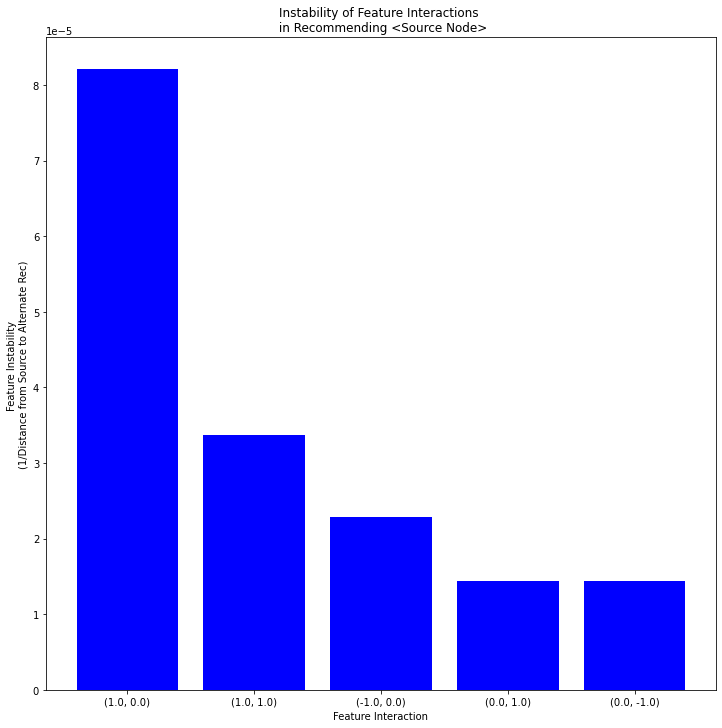

In [548]:
source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
feat_ranges = get_num_range(data, dense_features)
feat_scaler = 1/np.asarray(feat_ranges)

print(" Prelim Solution Progress:")
prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=5, k=20)
print("\n Low LR A* Search Progress:")
lr = feat_ranges[0] * 30
mid_discovered,solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, learning_rate=lr, k=100, max_cluster_size=20)
print("\n High LR A* Search Progress:")
lr = feat_ranges[0] * 5
refined_discovered,solution_clusters = a_star_search(source_node, mid_discovered, feat_ranges, k=50, learning_rate=lr, max_cluster_size=10)

plt.rcParams["figure.figsize"] = (12,12)
sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
display_instability(sorted_clusters)

Dark Blue: Initial Search
Light Blue: A* High Learning Rate Search
Red: A* Low Refined Learning Rate Search


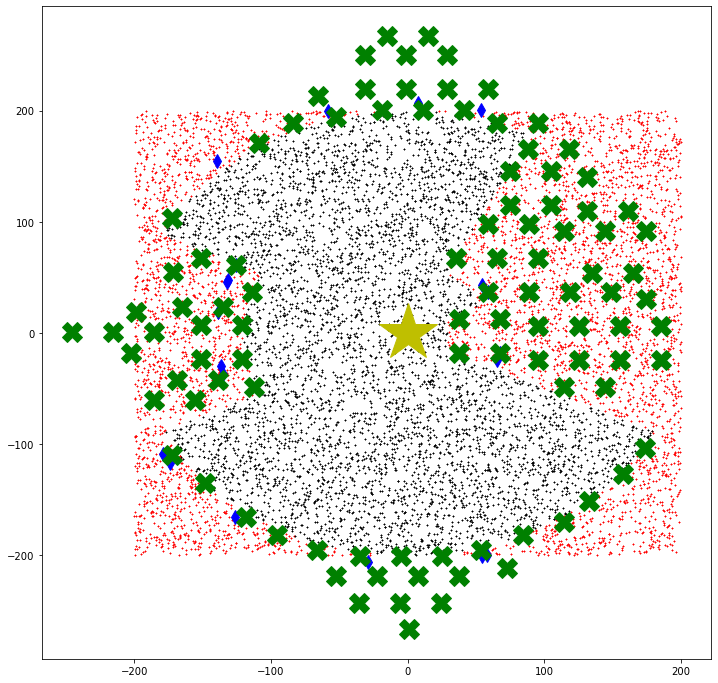

In [550]:
#Overlay true recs over feature space
nsamp = 10000
for _ in range(nsamp):
    point = np.random.uniform(low=-1*feat_range, high=feat_range, size=(nfeats,))
    query_node = Node(point, None)
    rec = query_synth_model(ground_truth_importance, source_node, query_node)
    if rec == 0:
        plt.plot(point[0],point[1],'k+',markersize=2)
    else:
        plt.plot(point[0],point[1],'r+',markersize=2)
        
plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=60)

        #  0.   1.   2.  3.   4.  5.   6.  7
colors = ['b^','gX','r','c^','k','md','y','bd']
#Display solutions of GD-FETS using discovered list
def plot_solutions(source_node, discovered,color_index=0,markersize=10):
    plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
    for point in discovered:
        plt.plot(point.position[0],point.position[1],colors[color_index],markersize=markersize)
    
plot_solutions(source_node, prelim_discovered,color_index=7,markersize=10)
plot_solutions(source_node, mid_discovered,color_index=1,markersize=20)
#plot_solutions(source_node, refined_discovered,color_index=3,markersize=20)
print("Dark Blue: Initial Search")
print("Light Blue: A* High Learning Rate Search")
print("Red: A* Low Refined Learning Rate Search")

(1.0, 0.0) : bD
(1.0, 1.0) : gD
(-1.0, 0.0) : rD
(0.0, 1.0) : cD
(0.0, -1.0) : kD
(-1.0, 1.0) : mD
(-1.0, -1.0) : yD
(1.0, -1.0) : b*


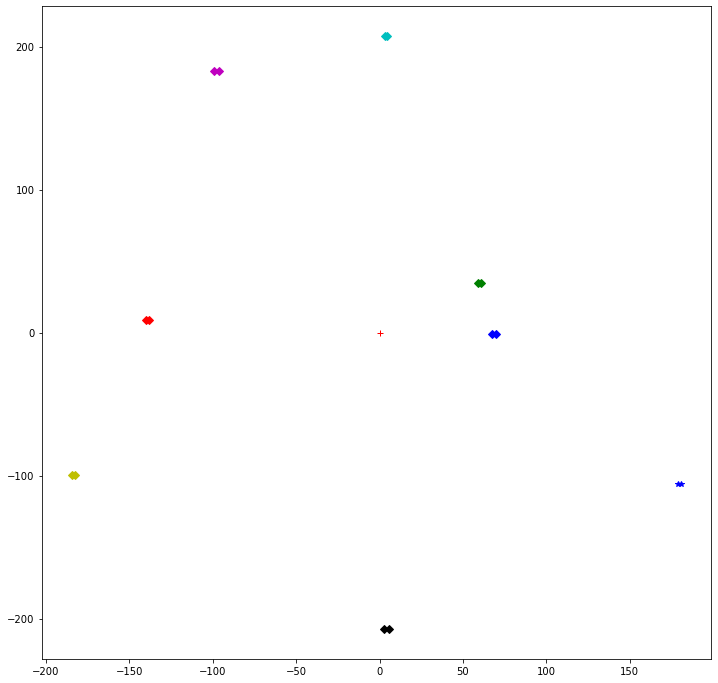

In [495]:
#Display solutions of GD-FETS using solution_clusters
plt.plot(source_node.position[0],source_node.position[1],'r+')
i=0
for cluster in solution_clusters:
    print(cluster,':',colors[i])
    for point in solution_clusters[cluster]:
        plt.plot(point[0],point[1],colors[i])
    i+=1

Test on Higher Dimensional Feature Space
-

In [553]:
d_dims = 10
source_node = Node(np.zeros(d_dims),0) #Want to explain this value

#Define scaling for features in synthetic "training data"
feat_ranges = np.zeros(d_dims) + 1000 #Assume all features have range 1000
feat_range = feat_ranges[0]
feat_scaler = 1/np.asarray(feat_ranges)

#Want GD-FETS to recreate these stability values thorugh local search
nclusters = 5
values = np.random.randint(low=0,high=feat_range, size=d_dims) #distance of cluster min to source_node
ground_truth_importance = {}
for i in range(nclusters):
    cluster_key = tuple(np.random.randint(low=-1,high=2, size=d_dims))
    ground_truth_importance[cluster_key] = values[i]
ground_truth_importance[tuple(np.zeros(d_dims))] = feat_range * 0.75 #default for every other feature interaction

In [554]:
ground_truth_importance

{(0, 1, -1, 0, 0, 1, 1, -1, 0, -1): 158,
 (1, 1, -1, 1, 0, -1, 0, 0, 0, 1): 895,
 (0, -1, 0, 1, 0, 0, 1, 0, 0, -1): 299,
 (0, 1, -1, 1, 0, 0, 0, 1, 0, -1): 113,
 (0, 1, 1, 1, 1, 0, -1, -1, -1, -1): 479,
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 750.0}

In [561]:
print(" Prelim Solution Progress:")
prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=50, k=100)

print("\n Intermediate A* Solution Progress:")
lr = feat_ranges[0] * 0.5
mid_discovered,solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, learning_rate=lr, k=100, max_cluster_size=20)

 Prelim Solution Progress:
1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


75767778798081828384858687888990919293949596979899100
 Intermediate A* Solution Progress:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Nodes Visited: 1548
Nodes Generated: 2005
Visited Length: 1910
Cluster Denies: 1448


In [562]:
sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
sorted_clusters

array([[1716834.1950937698,
        (0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0)],
       [1733524.1704081488,
        (-1.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0)],
       [1823082.5586566357,
        (0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0)],
       [1835538.7367886743,
        (0.0, 0.0, 1.0, 1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0)],
       [1851198.448994122,
        (0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)]], dtype=object)

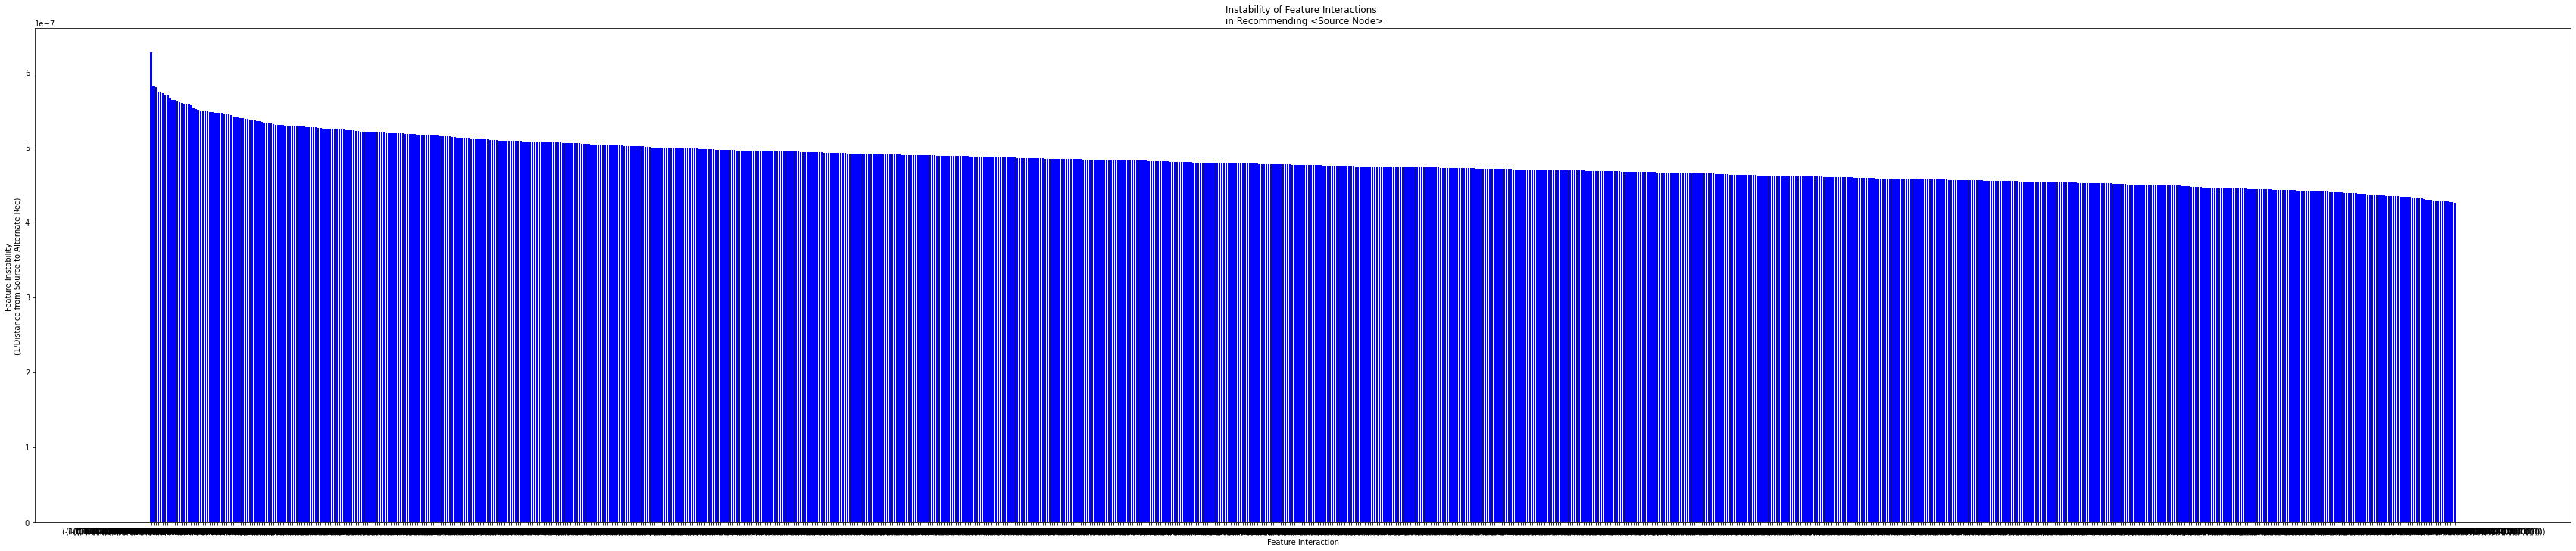

In [432]:
#Display results
solution_clusters = {}
max_cluster_size = 1000

for query_node in prelim_discovered:
    solution_clusters, full_cluster = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler, max_cluster_size)

plt.rcParams["figure.figsize"] = (60,12)
sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
display_instability(sorted_clusters)

TODO:
-
- Synthetic model should have continuous importance between features
- How to push GD-FETS adj neighbor search out of cluster when it is satisfied --> promote moving into space of adjacent feature-interaction cluster instead of redundantly showing density of feature-interactions in optimal cluster... A* should be able to identify optimal feature-interaction clusters given a high LR, to essentially walk down adjacent feat-int clusters
- A* Cluster search should redundantly look at small neighborhood distributed in cluster, and search each of them downward, saving the solution node that gives the smallest distance
- synthetic model that creates a smooth & continuous decision boundary between feature interactions
- Use mean of solutions in clusters as measure of feature stability?
- Implement LIME/SHAP to give comparison of their performance using a Ground Truth decision boundary, to that of GD-FETS
- Implement one-way feature-interaction for GD-FETS for direct comparison to LIME
- T-tests to demonstrate signifiance of GD-FETS identifying the same feature interactions as expreesed in the GT explanation --> Only shortest distance is logical, as the average would be impacted by search bias artefacts... can show this once solutions hug the decision boundary in each solution cluster

----
- Adjust abstract to provide brief intro on importance of deep recsys/DNN explainability, followed by a majority of key features of GD-FETS
- Describe evaluation methodology in manuscript, and describe results
- Would like to do: Use T-SNE to project categorical embedding vectors from 4 dimension to 2 (reduce complexity of search space), can also collapse the dimensionality to a single dimension, although => information loss
- Use generators to dynamically create one-hot encoding labels for training embedding inversion models, for features with very large dictionary sizes, due to memory constraints
- Future Direction: Implement reinforcement learning agent to repalce the A* search engine, as RL policy can learn the most common explanability for a given model and feature values, which can be leveraged fro search.

Prev:
-
- Generate Ground Truth (GT) evaluation model with manufactured decision boundary surrounding source node, to provide a GT of explainability as defined by the function that creates the search space. This function will be used to compare the accuracy of GD-FETS to LIME. It should build the decision boundary given input parameters of which feature interactions should have what degree of instability.
- Set limit of q solutions found per multi-way feature interaction, after finding k solutions with high learning rate
- find_adjs() to take certain step size based on learning rate
- Reject the generation of an adjacent node if it is too close to an existing solution, such that local maxima aren't overrepresented, giving a chance to find global maxima for a given feature-interaction cluster
- Implement solutions clustering method for identifying which multi-way feature interaction a sample is expressing
- Implement method to display the magnitude of instability for top-k feature interactions
- Use 2-3 Std devs of each feature of training data as feat_range for data distribution to ignore outliers that would cause certain features to be traversed with too large a step size

Rejected Ideas
-
- Set limit of k solutions found per multi-way feature interaction, such that after k solutions in a single feature-interaction cluster are found, every node in the priority queue that is a member of that cluster is removed, so that only other feature-interaction clusters are searched. =>  > k*(top_n_feat_ints_desired) must be identified --> How else to prevent the overwelming redundance of the single closest feature interaction in explaining a recommendation/prediction? --> Answer: larger learning rate s.t. more areas are covered, but this leads to less specificity near decision boundary of optimal positions
- Modify find_adjs() to only generate adjacents in direction of source node, to reduce memory complexity of frontier priority queue